In [72]:
# setup
from IPython.display import display,HTML
display(HTML('<style>.prompt{width: 0px; min-width: 0px; visibility: collapse}</style>'))
display(HTML(open('../rise.css').read()))

# imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import math
import profile
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression

%matplotlib inline
sns.set(style="whitegrid", font_scale=1.5, rc={'figure.figsize':(12, 6)})

<h1>Introduction to Algorithms</h1>

<h2>Last Time: Human Genome</h2>

We discussed the Human Genome Project. The human genome is too long to sequence directly, so we broke it into fragments, then stitched the pieces back together by thinking of the fragments as locations in the Traveling Salesman Problem. We saw how some problems can be solved by transforming them into other problems, and how algorithmic efficiency is not just about speed. At large scale, it is the difference between your program working and not working.

This time we will deal with a more subtle speedup.

<h2>Testing for genetic diseases</h2>

Now suppose that Arnold had his genome sequenced. He is worried that he has a genetic disease, Beta. In our simplified discussion, a person has the Beta disease iff a string B appears in his genomic sequence. 

Denoting Arnold's genetic sequence by A and the sequence of Beta disease by B, we want to know if B is a substring of A. And, how long does a computer need to return the answer?

In [73]:
def create_random_string(string_length:int)->str:
    '''Input: string_length, ant integer.
       Output: a string selected uniformly at random of length string_length on the letters 'a','c','g','t'
    '''
    alphabet = ['a','c','g','t'] #alphabet for genome
    random_genome = ''.join(random.choices(alphabet,k=string_length))
    return random_genome
N = 10_000_000 #Genome length
M = 50_000 #length of Beta diseases's sequence
A = create_random_string(N) #arnold's genome
B = create_random_string(M) #the gene B.
if B in A: #Checks if the gene B appears in the genome A. But how exactly does it work?
    print("Sorry, Arnold. You've got the Beta disease")
else:
    print("No disease here")

No disease here


In this lecture, we will study the line of code ```B in A```. How exactly does it work under the hood? Is it feasible to test a full sized genome for the beta gene? Does it always work?

<h2>Average-Case Runtime</h2>
Above, we see that when N=10,000,000 and M= 5,000 the program takes half a second to run. As N and M increase, we expect that the program will take longer. 

Programs are often either faster than the blink of an eye or intollerably slow. At a certain point, the program will take so long to run that Arnold will die of natural causes before he learns the result of the test. For example, when N = 3 billion, we can't even generate Arnold's genome, let alone search it for the Beta gene.



In [74]:
# Lol don't run this. It crashes the notebook
# big_N = 3_000_000_000
# big_genome = create_random_string(big_N) #even generating this string takes a long time.



A natural measure of the efficiency of an algorithm is the runtime, as measured by the elapsed time between when the algorithm begins and when it ends. This is also called the <i>wall time</i>. 

The average-case runtime (of ```in```) for parameters $N$ and $M$ is the average runtime (of 'in') over all genomes of length $N$ and all genes of length $N$. We can measure a typical runtime by choosing the inputs randomly and measuring the wall time. We can analyze for small values of N and M and extrapolate to larger values. The typical runtime should be about the same as the average runtime.

First, let's create a function that runs ```A in B``` and returns the amount of time that the funciton takes.

In [75]:
def time_substring_search(N:int,M:int)->float: #Let's assume N<10,000,000 and M<50,000
    genome = A[:N] #We take the first N letters of Arnold's genome.
    gene = B[:M] #We take the first M letters of Beta. This saves us time compared to generating A and B at random.
    start_time= time.time()
    gene in genome  #Be careful that only the line of code that you are interested in timing gets called here.
    end_time = time.time()
    return end_time-start_time #returns the elapsed time
#For example,
time_substring_search(5000,100)

2.765655517578125e-05

Let's now fix M=100 and allow N to vary from 500 to 10,000. We will plot the amount of time that it takes to check for the gene.

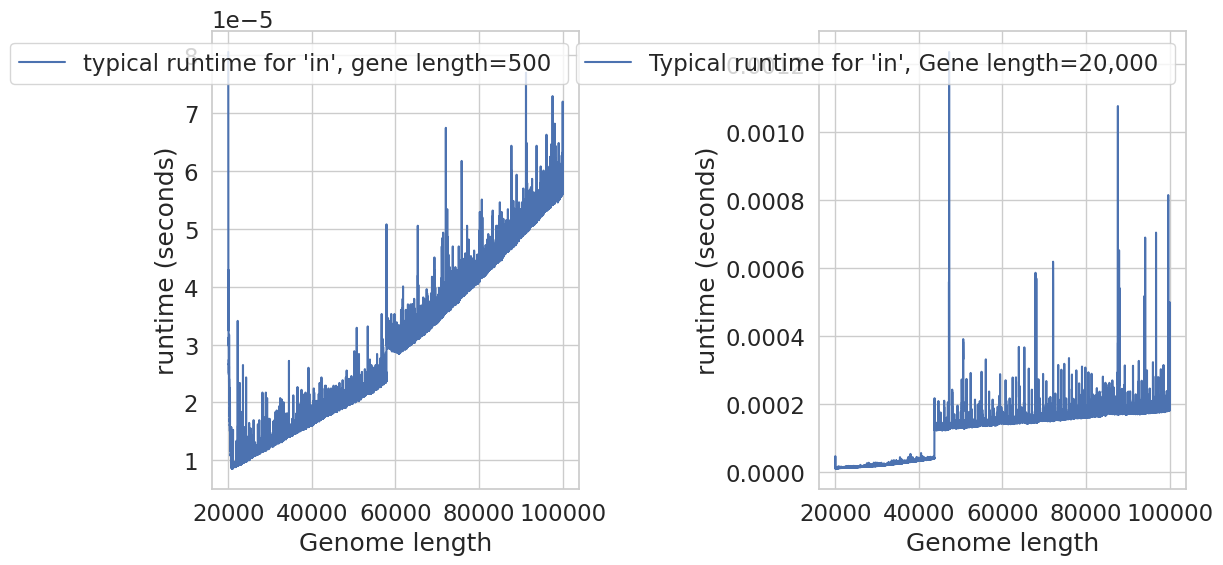

In [76]:
inputs = list(range(20_000,100_001))

outputs = []
for input in inputs:
    outputs.append(time_substring_search(input, 500))

plt.subplot(1,2,1)
plt.plot(inputs, outputs, label='typical runtime for \'in\', gene length=500 ')
#plt.text(94,1000,'$n_0$', fontsize=18, color='g')

plt.xlabel("Genome length")
plt.ylabel('runtime (seconds)')
plt.legend()

inputs = list(range(20_000,100_001))
outputs = []
for input in inputs:
    outputs.append(time_substring_search(input, 20_000))

plt.subplot(1,2,2)
plt.plot(inputs, outputs, label='Typical runtime for \'in\', Gene length=20,000 ')
#plt.text(94,1000,'$n_0$', fontsize=18, color='g')
plt.xlabel("Genome length")
plt.ylabel('runtime (seconds)')
plt.legend()
plt.tight_layout()
plt.show()

The spikes are probably artifacts caused by the processor switching tasks.

With the exception of the spikes, the runtime appears to scale linearly in N, the genome length for both values of $M$. We say that the runtime is $O(N)$, or <i>linear time</i>. Doubling the input size (roughly) doubles the runtime. We will see a real definition later. It's hard to beat this sort of performance, because if the genome doubles, we expect to have to double our search.

When $M=20,000$, the slope does not change significantly. The jump around $N=4,000$ probably indicates that ```in``` is implemented using different algorithms, depending on the parameters $N$ and $M$.

<h2>Python's Standard Implementation of 'in'<h2>

You can find the implementation of ```in``` in Cpython [here](https://github.com/python/cpython/blob/main/Objects/stringlib/fastsearch.h).
According to this stack exchange [thread](https://stackoverflow.com/questions/18139660/python-string-in-operator-implementation-algorithm-and-time-complexity), it uses the [Boyer-Moore algorithm](https://en.wikipedia.org/wiki/Boyer%E2%80%93Moore_string-search_algorithm).

The built-in Python methods are extremely fast. If you want to write fast code, then you should rely on built-in methods rather than implementing the algorithms that you learn in this class. We will seek to understand the techniques that go into writing these built-in methods. We will illustrate the ideas in Python, but we should not expect our implementations to be as fast as optimized libraries.

<h2>Naive implementation of string search.</h2>

Let's investigate how one might implement the  ```in``` function. The naive method is just to check each substring of Arnold's genome to see if it is the Beta gene.

But there are several ways test substrings to see if they are the beta gene. We give three examples.

In [77]:
def naive_string_comparsion(str1,str2): #assume str1,str2 are strings. Returns True iff str1==str2.
    if len(str1) != len(str2):
        return False #Two strings can only be equal if they have the same length.
    else:
        returning_true = True
        for index in range(len(str1)): #loops through the both str1 and str2
            returning_true = returning_true and ( str1[index] == str2[index]) #checks them letter by letter.
    return returning_true

The naive string comparison method can be improved by using an early return.

In [78]:
def string_comparison_early_termination(str1, str2): #same as naive_string_comparison, but terminates early if there is a mismatch.
    if len(str1) != len(str2):
        return False #Two strings can only be equal if they have the same length.
    else:
        returning_true = True
        for index in range(len(str1)): #loops through the both str1 and str2
            if ( str1[index] != str2[index]): #checks them letter by letter.
                   return False #stop at the first letter where the two strings differ.
        return True #If you make it through both strings, return True.

Of course, the built-in method is probably fastest.

In [79]:
def builtin_string_comparison(str1, str2):
    return str1 == str2 #use the builtin operator. It should be faster, but it's kind of cheating.

For each string comparison algorithm, we obtain a different algorithm for ```in```. Higher order functions allow us to write a single function that allows us to access all three algorithms.

In [80]:
comparison_functions = [naive_string_comparsion, string_comparison_early_termination, builtin_string_comparison]


In [81]:
def naive_in(gene, genome, comparison_function): #gene and genome are strings. Comparison function is one of our 3 comparison functions.
    for index in range(len(genome) - len(gene) + 1 ):
        if comparison_function(genome[index: index+len(gene)], gene):
            return True
    return False
def test_naive_in(): #checks that naive_in works correctly for each of the 3 comparison functions.
    for c in comparison_functions:
        assert naive_in("cgc","atcgcat",c)
        assert not naive_in("tt", "atcgcat",c)
        assert naive_in("cat", "atcgcat",c)
test_naive_in()

<h2>Timing our implementations of 'in'</h2>

Now we can create a timer for our naive implementation of ```in```.

In [82]:
def time_naive_in(N,M,comparison_function): #Let's assume N<10,000,000 and M<50,000
    genome = A[:N]
    gene = B[:M]
    start_time= time.time()
    naive_in(gene, genome, comparison_function)
    end_time = time.time()
    return end_time-start_time
#For example,
for c in comparison_functions:
    time_naive_in(5000,100,c)

We create new plots to compare the performance of our naive implementation with the built-in implementation. The naive implementation is so much slower that we need to reduce the input sizes and adjust the x-axis.

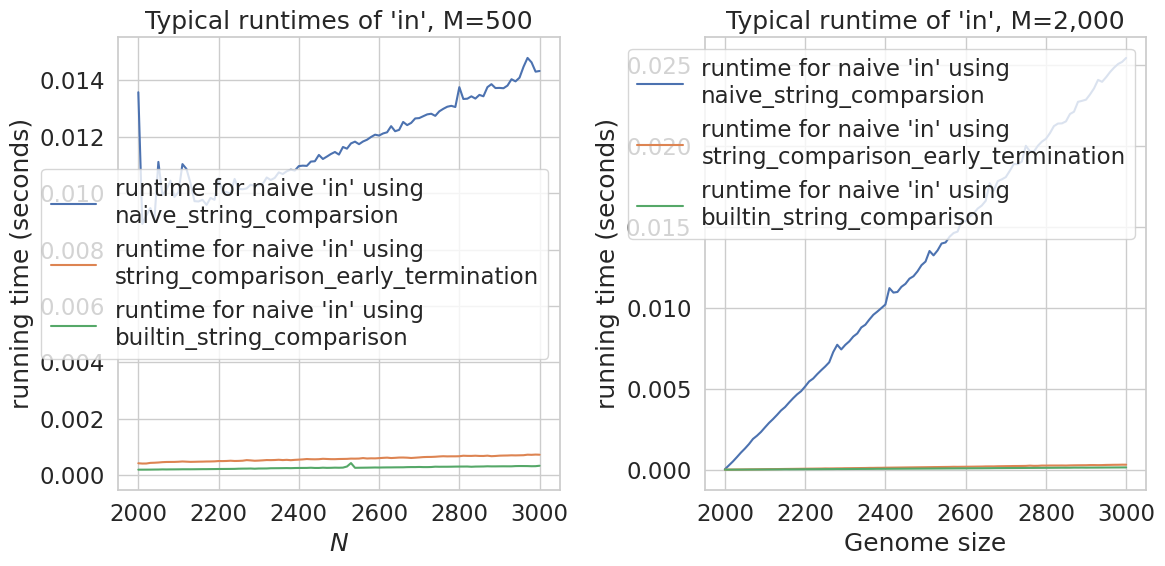

In [63]:
inputs = list(range(2_000,3_001,10))

plt.subplot(1,2,1)
for c in comparison_functions:
    outputs = []
    for input in inputs:
        outputs.append(time_naive_in(input, 500,c))
    plt.plot(inputs, outputs, label="runtime for naive \'in\' using \n" + f'{c.__name__}')


#plt.text(94,1000,'$n_0$', fontsize=18, color='g')
plt.title("Typical runtimes of \'in\', M=500")
plt.xlabel("$N$")
plt.ylabel('running time (seconds)')
plt.legend()
inputs = list(range(2_000,3_001, 10))

plt.subplot(1,2,2)
for c in comparison_functions:
    outputs = []
    for input in inputs:
        outputs.append(time_naive_in(input, 2_000,c))
    plt.plot(inputs, outputs, label="runtime for naive \'in\' using \n" + f'{c.__name__}')
#plt.text(94,1000,'$n_0$', fontsize=18, color='g')
plt.title("Typical runtime of \'in\', M=2,000")
plt.xlabel("Genome size")
plt.ylabel('running time (seconds)')
plt.legend()
plt.tight_layout()

plt.show()

When $M$ increases, the waste incurred by not terminating string comparison early completely ruins the runtime. It's a bit hard to see, but the slope of the runtimes using naive naive string comparison increases significantly. Let's recreate the chart above without the naive string comparsion.

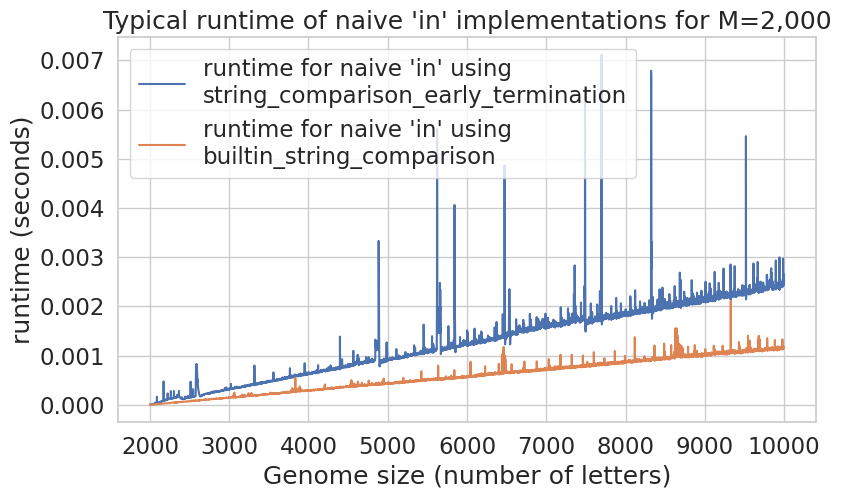

In [64]:
inputs = list(range(2_000,10_001))

plt.figure(figsize=(9,5))
good_comparison_functions = [string_comparison_early_termination, builtin_string_comparison]
for c in good_comparison_functions:
    outputs = []
    for input in inputs:
        outputs.append(time_naive_in(input, 2_000,c))
    plt.plot(inputs, outputs, label="runtime for naive \'in\' using \n" + f'{c.__name__}')
#plt.text(94,1000,'$n_0$', fontsize=18, color='g')
plt.title("Typical runtime of naive \'in\' implementations for M=2,000")
plt.xlabel("Genome size (number of letters)")
plt.ylabel('runtime (seconds)')
plt.legend()
plt.show()

<h2>Worst-case runtimes</h2>

The naive ```in``` algorithm is supposed to run in quadratic time, $O(NM)$, because it involves a loop (the loop over ```index```) (of length $N-M$), and each iteration of the loop performs a string comparison, which itself involves another loop (of length M or smaller). 

The inner loop suggests that string comparison itself takes linear time. However, in our simulations, we saw that it only takes constant time, on average.



In [65]:
def time_string_comparison(input_size):
    str = create_random_string(input_size)
    str2 = create_random_string(input_size)
    start_time = time.time()
    string_comparison_early_termination(str, str2)
    end_time = time.time()
    return end_time-start_time

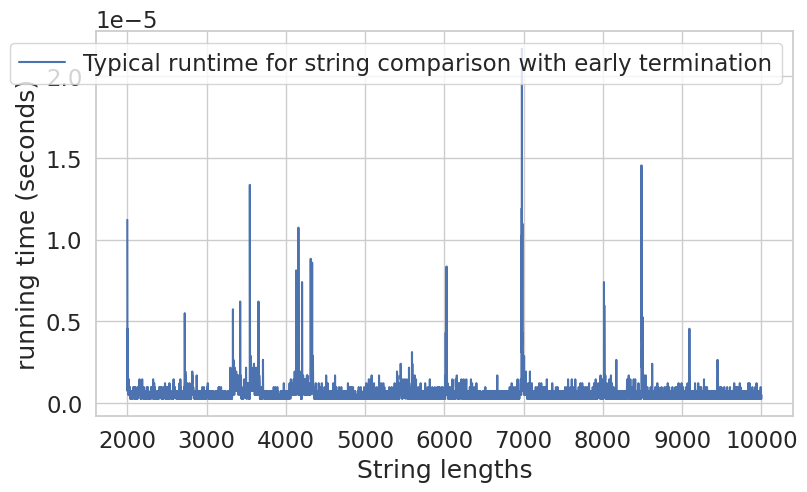

In [66]:
inputs = list(range(2_000,10_001))
outputs = []
for input in inputs:
    outputs.append(time_string_comparison(input))

plt.figure(figsize=(9,5))
plt.plot(inputs, outputs, label='Typical runtime for string comparison with early termination')
#plt.text(94,1000,'$n_0$', fontsize=18, color='g')
plt.xlabel("String lengths")
plt.ylabel('running time (seconds)')
plt.legend()
plt.show()

The runtime of the string comparison is independent of the lengths of the strings! The reason for this is that we are discussing average and typical runtimes. In the typical case, if both strings are drawn uniformly at random, then we will be able to complete the comparison after looking at just a few letters early in both strings.

<h2>Worst Case Runtime</h2>
In the real world, strings are not drawn uniformly at random. Even though the typical behavior may be good, certain inputs can cause the problems for the algorithm. By analyzing the worst case inputs of particular values N and M, we can guarantee that our program always performs well.

Usually, we need to know how the algorithm works in order to find the worst case input. For example, it would be tricky to find the worst case input of a built-in function without looking at its implementation.

We know how string comparison with early termination behaves, and this allows us to determine the worst case inputs of given sizes. If ```str1==aaat``` and ```str2==aaaa```, then the two strings only differ in the last letter. This means that our string comparison function will need to examine each letter and will not have the chance to terminate early.

Waving our hands, we can see that a worst case input for the naive ```in``` algorithm is given by the function below.

In [67]:
def worst_case_inputs(N,M): #Returns a genome and gene that are worst-case, for their sizes.
    genome = "a"*N
    gene = "a"*(M-1)+"t"
    return genome, gene

print(worst_case_inputs(10,3))

('aaaaaaaaaa', 'aat')


In [68]:
def time_naive_in_worst_case(N,M,comparison_function):
    genome, gene = worst_case_inputs(N,M)
    start_time= time.time()
    naive_in(gene, genome, comparison_function)
    end_time = time.time()
    return end_time-start_time

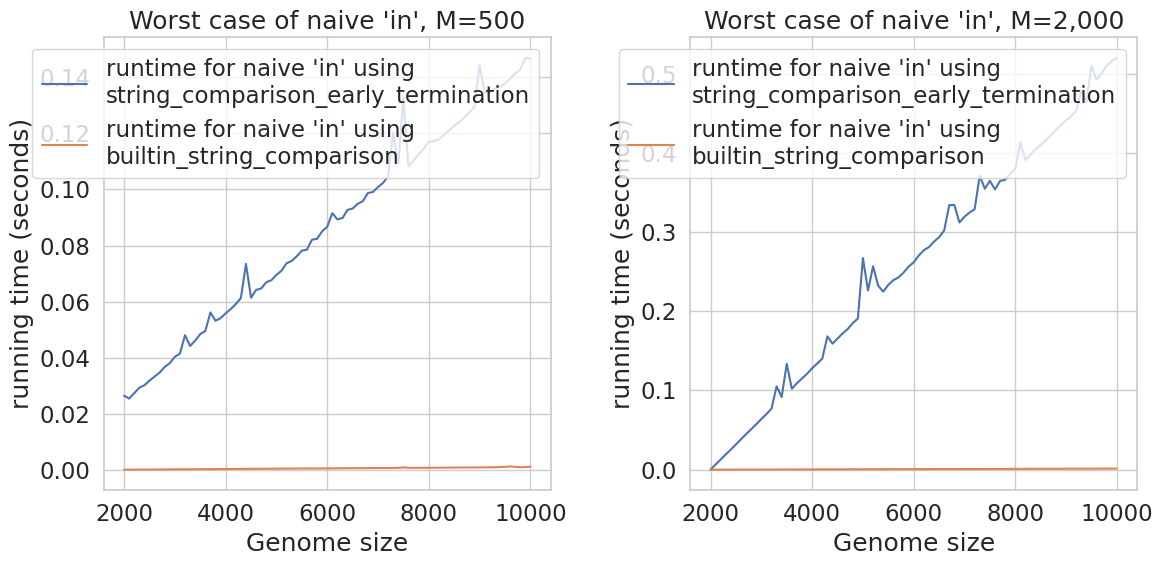

In [69]:
inputs = list(range(2_000,10_001,100))

plt.subplot(1,2,1)
good_comparison_functions = [string_comparison_early_termination, builtin_string_comparison]
for c in good_comparison_functions:
    outputs = []
    for input in inputs:
        outputs.append(time_naive_in_worst_case(input, 500,c))
    plt.plot(inputs, outputs, label="runtime for naive \'in\' using \n" + f'{c.__name__}')
#plt.text(94,1000,'$n_0$', fontsize=18, color='g')
plt.title("Worst case of naive \'in\', M=500")
plt.xlabel("Genome size")
plt.ylabel('running time (seconds)')
plt.legend()
inputs = list(range(2_000,10_001,100))

plt.subplot(1,2,2)
good_comparison_functions = [string_comparison_early_termination, builtin_string_comparison]
for c in good_comparison_functions:
    outputs = []
    for input in inputs:
        outputs.append(time_naive_in_worst_case(input, 2_000,c))
    plt.plot(inputs, outputs, label="runtime for naive \'in\' using \n" + f'{c.__name__}')
#plt.text(94,1000,'$n_0$', fontsize=18, color='g')
plt.title("Worst case of naive \'in\', M=2,000")
plt.xlabel("Genome size")
plt.ylabel('running time (seconds)')
plt.legend()
plt.tight_layout()
plt.show()

In the worst case for our naive algorithm, the runtime is highly sensitive to the size of $M$. It is suprising that this does not need to be the case. Let's check these worst-case scenarios on the builtin algorithm for ```in```. Keep in mind that this may not actually be the worst case for the builtin implementation. Since we don't know how the builtin implementation works, we can't say what the worst case is.

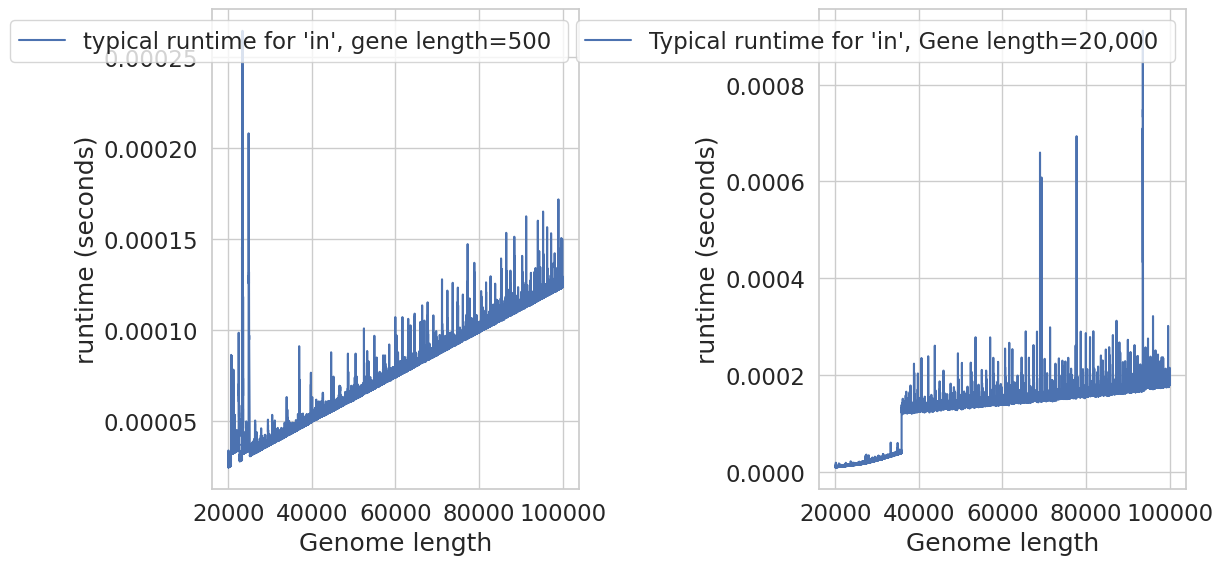

In [70]:
def time_substring_search_worst_case(N:int,M:int)->float:
    genome, gene = worst_case_inputs(N,M)
    start_time= time.time()
    gene in genome
    end_time = time.time()
    return end_time-start_time

inputs = list(range(20_000,100_001))

outputs = []
for input in inputs:
    outputs.append(time_substring_search_worst_case(input, 500))

plt.subplot(1,2,1)
plt.plot(inputs, outputs, label='typical runtime for \'in\', gene length=500 ')
#plt.text(94,1000,'$n_0$', fontsize=18, color='g')

plt.xlabel("Genome length")
plt.ylabel('runtime (seconds)')
plt.legend()

inputs = list(range(20_000,100_001))
outputs = []
for input in inputs:
    outputs.append(time_substring_search(input, 20_000))

plt.subplot(1,2,2)
plt.plot(inputs, outputs, label='Typical runtime for \'in\', Gene length=20,000 ')
#plt.text(94,1000,'$n_0$', fontsize=18, color='g')
plt.xlabel("Genome length")
plt.ylabel('runtime (seconds)')
plt.legend()
plt.tight_layout()
plt.show()

<h2>Knuth-Morris-Pratt</h2>

The [Knuth-Morris-Pratt algorithm](https://www.cs.jhu.edu/~misha/ReadingSeminar/Papers/Knuth77.pdf) is a classic example of how pre-computing a table can be used to expedite computation. It runs in $O(N+M)$ time, meaning that we should be able to increase M without increasing the runtime very much.

It demonstrates it is possible to achieve good performance for implementing ```in``` on all inputs.

<h3>Backtracking: The source of inefficiency</h3>

Let's consider the naive implementation of ```in``` where string comparison with early termination is used.

Suppose that our gene is ```atatgatatgc``` and our genome is ```attagcattaatatgatatgc```. 

<details>
<summary>Let's write some of the steps of the naive algorithm to see why it is inefficient.</summary>

We write the gene above the genome. We mark the position in the inner loop (which checks string equality) using ⬇. We mark the position in the outer loop (which loops through the genome) using ⬆.

```
⬇
atatgatatgc
atatgcatatatatgatatgc
⬆
```
```
 ⬇
atatgatatgc
atatgcatatatatgatatgc
⬆
```
```
  ⬇
atatgatatgc
atatgcatatatatgatatgc
⬆
```
```
   ⬇
atatgatatgc
atatgcatatatatgatatgc
⬆
```
```
    ⬇
atatgatatgc
atatgcatatatatgatatgc
⬆
```
```
     ⬇
atatgatatgc
atatgcatatatatgatatgc
⬆
```
Since $a\neq c$, we terminate the inner loop and increment the outer loop. We shift the gene over by 1.
```
 ⬇
 atatgatatgc
atatgcatatatatgatatgc
 ⬆
```
Since $a\neq t$, we terminate the inner loop and increment the outer loop. We shift the gene over by 1.

```
  ⬇
  atatgatatgc
atatgcatatatatgatatgc
  ⬆
```
```
   ⬇
  atatgatatgc
atatgcatatatatgatatgc
  ⬆
```
```
    ⬇
  atatgatatgc
atatgcatatatatgatatgc
  ⬆
```

Again, $a\neq g$, so we detect a mismatch and we increment the outer loop and shift the gene over by 1 and re-start the inner loop. The algorithm continues in this way.

Inefficiency arises because the position of ⬇ moves backwards to meet ⬆. In the worst case, (when gene = aaaa...t and genome = aaaa...), ⬇ will move forwards len(gene) times, only to move backwards len(gene)-1 times once a mismatch is detected between the last letter of gene (t) and the corresponding letter of genome (a).
</details>



The Knuth-Morris-Pratt algorithm allows us to dispense with the backtracking of the naive algorithm. We dispense with the inner loop entirely and instead always ensure that the gene is properly aligned over the genome. 
<details>
<summary>Here is an example of the Knuth-Morris-Pratt algorithm.</summary>

```
atatgatatgc
atatgcatatatatgatatgc
⬆
```
```
atatgatatgc
atatgcatatatatgatatgc
 ⬆
```
```
atatgatatgc
atatgcatatatatgatatgc
  ⬆
```
```
atatgatatgc
atatgcatatatatgatatgc
   ⬆
```
```
atatgatatgc
atatgcatatatatgatatgc
    ⬆
```
```
atatgatatgc
atatgcatatatatgatatgc
     ⬆
```

Now we detect that $a\neq c$. We shift the gene to the right by the smallest amount so that it matches the last few letters of the genome. Since the last few letters of the genome already match the last few letters of the gene, we can do this by examining the gene alone, without worrying about the genome at all! The last letter in the gene was 'g', which has only occured for the first time. We therefore need to shift the gene all the way past g.

```
     atatgatatgc
atatgcatatatatgatatgc
     ⬆
```

We find that $a\neq c$, so we need to shift the gene again.

```
      atatgatatgc
atatgcatatatatgatatgc
     ⬆
```

```
      atatgatatgc
atatgcatatatatgatatgc
      ⬆
```
```
      atatgatatgc
atatgcatatatatgatatgc
       ⬆
```
```
      atatgatatgc
atatgcatatatatgatatgc
        ⬆
```
```
      atatgatatgc
atatgcatatatatgatatgc
         ⬆
```
```
      atatgatatgc
atatgcatatatatgatatgc
          ⬆
```

Another mismatch, so we shift the gene again. This time, an interesting phenomenon occurs: we only need to shift the gene over twice, due to a repeated pattern in the gene.

```
        atatgatatgc
atatgcatatatatgatatgc
          ⬆
```
```
        atatgatatgc
atatgcatatatatgatatgc
           ⬆
```
```
        atatgatatgc
atatgcatatatatgatatgc
            ⬆
```
We must shift the pattern again.

```
          atatgatatgc
atatgcatatatatgatatgc
            ⬆
```
```
          atatgatatgc
atatgcatatatatgatatgc
             ⬆
```
```
          atatgatatgc
atatgcatatatatgatatgc
              ⬆
```

From this point, it should be pretty clear that the rest of the pattern matches.
</details>

The Knuth-Morris-Pratt algorithm is better than the naive 'in' implementation because it only requires scanning through the genome once, without the need to backtrack when mismatches are found. The symbol ⬆ only ever moves forward, and either the ⬆ moves forward or the start of the gene moves forward.

Now let us address the question: How do we know how much to shift the gene when a mismatch is identified?

Before running the procedure described above, we pre-compute a table that describes how much to shift the gene each time a mismatch is identified. This is possible because when a mismatch is identified at the $j^{th}$ letter of the gene, we have already checked that the previous letters of the gene match with the previous letters of the genome, so we can decide how much to move the gene by investigating only the gene itself.

In our running example, the gene is ```atatgatatgc```. When we identify a mismatch at the $j^{th}$ letter, we must identify the smallest shift $s$ such that ```gene[s:j]==gene[:j-s]``` and ```gene[j]!=gene[s]```. We can do this directly by examining all possible shifts and choosing the smallest one that fits the criteria. 

Since the gene is much smaller than the genome, we don't care about how long it takes to do this.

The table can be computed faster by using a techinque called <i>dynamic programming</i>. We will see this later in the course.

In [71]:
def compute_table(gene:str)->list[int]: 
    '''Input: gene is a string. 
       Output: a list of integers. The jth integer is the number of indices to shift the gene over when a mismatch occurs at index j.
    '''
    table = []
    for j,g in enumerate(gene):
        shift_when_mismatch_at_j = min([s for s in range(j+1) if gene[:j-s]==gene[s:j] and gene[j]!= gene[j-s]], default = j+1)
        table.append(shift_when_mismatch_at_j)
    return table

def test_compute_table():
    gene = "abcabcacab"
    print(compute_table(gene))

    answer=  [ j - i +1 for j,i in enumerate([0,1,1,0,1,1,0,5,0,1])] #See Knuth's paper, keep in mind he starts indexing at 1 instead of 0.
    assert compute_table(gene)== answer
test_compute_table()

[1, 1, 2, 4, 4, 5, 7, 3, 9, 9]


For the recitation, I will ask you to complete the implementation of the Knuth-Morris-Pratt algorithm by using this precomputed table. You will construct plots to compare the performance of Knuth-Morris-Pratt algorithm with the naive implementation of ```in```.

<h2>Review Questions</h2>

1. How can we directly measure the runtime of an algorithm? What are some difficulties with the measurement?
2. What is the relationship between the naive implementation of ```B in A``` vs ```C==D```, where A,B,C,D are strings? 
3. What are the differences and similarities between the "worst case," "average case," and "typical case" of runtimes?
4. How does the Knuth-Morris-Pratt algorithm avoid backtracking? What does this mean about its performance?